In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations



from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


import heapq
import matplotlib.pyplot as plt

In [ ]:
# read the data into the memory
df = pd.read_csv('processed_long_train.csv')

np.random.seed(26)
msk = np.random.rand(len(df)) < 0.6

train = df[msk]
test = df[~msk]

tests = np.array_split(test.sample(frac=1), 6)

SVM: 12 combinations of 11 features at a time will be used.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.6min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


SVC(C=0.1, gamma=1, kernel='linear', probability=True)


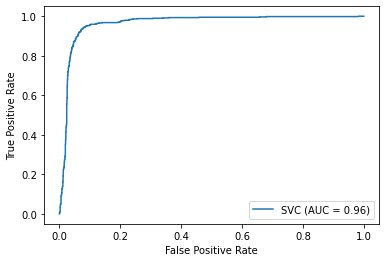

SVM cross validation 5-fold:
Best 11 selected features: ('Island', 'Promoter_Associated', 'percentage_pos', 'observed_to_expected_ratio', 'CCGG', 'CATG', 'GCGG', 'GGCG', 'CCGC', 'CGCC', 'GCGC') 
Highest cv (mean) score: 0.9275114155251142


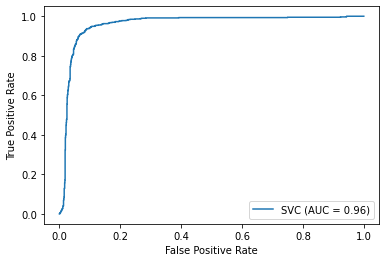

In [ ]:
### SVM ###

# chosen 12 features from the statistical testing (mutual info, chi2)
features = ['Island','Promoter_Associated','percentage_pos','observed_to_expected_ratio','CCGG','CATG','GCGG', 'GGCG', 'CCGC', 'CGCC', 'GCGC', 'CGCG']

# extract combinations of columns in length of 7
count = 11
comb = list(combinations(features, count))
print('SVM:', len(comb), 'combinations of', count, 'features at a time will be used.')

x_train_svm = train[features]
y_train_svm = train['Beta']

x_val_svm = tests[0][features]
y_val_svm = tests[0]['Beta']

x_test_svm = tests[1][features]
y_test_svm = tests[1]['Beta']



# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

param_grid = {'C': [0.1], 'gamma': [1,0.1], 'kernel': ['rbf', 'linear']}

grid = GridSearchCV(svm.SVC(probability=True), param_grid, refit=True, verbose=2, n_jobs=-1)
grid.fit(x_train_svm, y_train_svm)
    
print(grid.best_estimator_)

metrics.plot_roc_curve(grid.best_estimator_, x_val_svm, y_val_svm)  
plt.show() 

    

# Test cv scores of all possible combinations
cv_scores = []

for i in comb:
    data = x_train_svm[list(i)]
    # perform cross validation 5-fold
    cv = cross_val_score(grid.best_estimator_, data, y_train_svm, cv=5, n_jobs = -1)
    cv_scores.append(np.mean(cv))

max_cv_score = max(cv_scores)
max_cv_score_idx = cv_scores.index(max_cv_score)
print('SVM cross validation 5-fold:\nBest', count, 'selected features:', comb[max_cv_score_idx], '\nHighest cv (mean) score:', max_cv_score)
new_features = list(comb[max_cv_score_idx])


grid.best_estimator_.fit(train[new_features], y_train_svm)
metrics.plot_roc_curve(grid.best_estimator_, x_test_svm[new_features], y_test_svm)  
plt.show() 

In [ ]:
### KNN ### 
from sklearn.neighbors import KNeighborsClassifier

# chosen 12 features from the statistical testing (mutual info, chi2)
features = ['Island','Promoter_Associated','percentage_pos','observed_to_expected_ratio','CCGG','CATG','GCGG', 'GGCG', 'CCGC', 'CGCC', 'GCGC', 'CGCG']

x_train_knn = train[features]
y_train_knn = train['Beta']

x_val_knn = tests[2][features]
y_val_knn = tests[2]['Beta']

x_test_knn = tests[3][features]
y_test_knn = tests[3]['Beta']

In [ ]:
### KNN ### 
## GRID SEARCH ##
grid_params = {'n_neighbors': list(range(2,50,3)), 'weights': ("uniform", "distance")}
gs_knn = GridSearchCV(KNeighborsClassifier(), grid_params, cv = 5, verbose = 1)
gs_knn.fit(x_train_knn,y_train_knn)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 5, 8, 11, 14, 17, 20, 23, 26, 29,
                                         32, 35, 38, 41, 44, 47],
                         'weights': ('uniform', 'distance')},
             verbose=1)

In [ ]:
print(gs_knn.best_score_)
print(gs_knn.best_estimator_)
print(gs_knn.best_params_)
print(gs_knn.cv_results_)

0.8775684931506849
KNeighborsClassifier(n_neighbors=32, weights='distance')
{'n_neighbors': 32, 'weights': 'distance'}
{'mean_fit_time': array([0.02982035, 0.02284665, 0.02819948, 0.02232294, 0.02287526,
       0.02776899, 0.0362874 , 0.03912435, 0.03313069, 0.03952494,
       0.02781868, 0.02444487, 0.04162965, 0.03505149, 0.02262831,
       0.03340182, 0.02951589, 0.03399081, 0.0444768 , 0.03056774,
       0.03388829, 0.02751436, 0.03329964, 0.03245983, 0.0225616 ,
       0.03068604, 0.02882504, 0.02783217, 0.02806416, 0.02950821,
       0.03884387, 0.03818913]), 'std_fit_time': array([0.00946826, 0.00078476, 0.01082676, 0.00035326, 0.00102679,
       0.01078592, 0.01732512, 0.01280961, 0.01199074, 0.01416512,
       0.01095345, 0.0044114 , 0.01624617, 0.01055561, 0.00027655,
       0.01360835, 0.01032609, 0.01342097, 0.01107179, 0.01322416,
       0.01427959, 0.01038276, 0.01323683, 0.01089228, 0.0003455 ,
       0.01117353, 0.01102431, 0.01100258, 0.01086339, 0.01039788,
       0.0

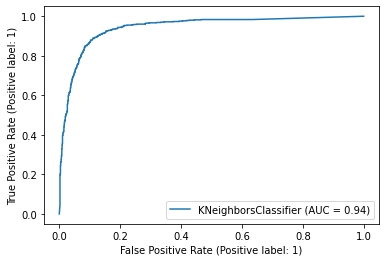

In [ ]:
metrics.plot_roc_curve(gs_knn.best_estimator_, x_val_knn, y_val_knn)  
plt.show()

In [ ]:
### KNN ###
# Mean accuracy for different n_neighbors
results_knn = pd.DataFrame(gs_knn.cv_results_)
results_knn = results_knn.sort_values(by=['rank_test_score'])
print(results_knn)
uniform = []
distance = []
mean_test_scores = results_knn['mean_test_score']
for item in range(len(mean_test_scores)):
    if results_knn['param_weights'][item] == 'uniform':
        uniform.append([results_knn['param_n_neighbors'][item], mean_test_scores[item]])
    if results_knn['param_weights'][item] == 'distance':
        distance.append([results_knn['param_n_neighbors'][item], mean_test_scores[item]])


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
27       0.027832      0.011003         0.426449        0.028554   
21       0.027514      0.010383         0.377756        0.011661   
31       0.038189      0.013273         0.432731        0.021911   
15       0.033402      0.013608         0.341797        0.013867   
23       0.032460      0.010892         0.390935        0.017193   
13       0.035051      0.010556         0.342140        0.022308   
11       0.024445      0.004411         0.324749        0.026939   
29       0.029508      0.010398         0.416748        0.015987   
17       0.033991      0.013421         0.353081        0.017210   
25       0.030686      0.011174         0.401334        0.020259   
19       0.030568      0.013224         0.362724        0.015187   
9        0.039525      0.014165         0.292291        0.021426   
14       0.022628      0.000277         0.459963        0.025015   
20       0.033888      0.014280         0.473575

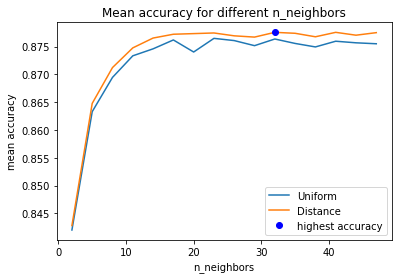

In [ ]:
### KNN ### 
# visualization
results_uniform = pd.DataFrame({'n_neighbors':[item[0] for item in uniform],'mean_cv_score':[item[1] for item in uniform]})
results_distance = pd.DataFrame({'n_neighbors':[item[0] for item in distance],'mean_cv_score':[item[1] for item in distance]})

plt.plot(results_uniform['n_neighbors'],results_uniform['mean_cv_score'], label='Uniform')
plt.plot(results_distance['n_neighbors'],results_distance['mean_cv_score'], label='Distance')
plt.plot(32, gs_knn.best_score_,'bo', label='highest accuracy')

# Add the labels and title
plt.gca().set(xlabel='n_neighbors', ylabel='mean accuracy',title='Mean accuracy for different n_neighbors')
plt.legend()
plt.show()

In [ ]:
### KNN ### 
knn = gs_knn.best_estimator_

count = 7
comb = list(combinations(features, count))

# Test cv scores of all possible combinations
cv_scores_knn = []
for i in comb:
    data = x_train_knn[list(i)]
    # perform cross validation 5-fold
    cv_knn = cross_val_score(knn, data, y_train_knn, cv=5, n_jobs = -1)
    cv_scores_knn.append(np.mean(cv_knn))
    print(cv_knn)

print(cv_scores_knn)

[0.88327626 0.88156393 0.88869863 0.85559361 0.89212329]
[0.88013699 0.87271689 0.88498858 0.85445205 0.88727169]
[0.87813927 0.88841324 0.89611872 0.86187215 0.89098174]
[0.87899543 0.89012557 0.89954338 0.8678653  0.89155251]
[0.88299087 0.8989726  0.90667808 0.87243151 0.90582192]
[0.89326484 0.90439498 0.90981735 0.88555936 0.91466895]
[0.86272831 0.86872146 0.87357306 0.84189498 0.88498858]
[0.86272831 0.88413242 0.88441781 0.84531963 0.87871005]
[0.86501142 0.88356164 0.88413242 0.84817352 0.8869863 ]
[0.86244292 0.88670091 0.88869863 0.85388128 0.8989726 ]
[0.88384703 0.89554795 0.90239726 0.86957763 0.90039954]
[0.86872146 0.88327626 0.88926941 0.85074201 0.8821347 ]
[0.86073059 0.87671233 0.87928082 0.84303653 0.88156393]
[0.86358447 0.88727169 0.89212329 0.85901826 0.89326484]
[0.8821347  0.90211187 0.9015411  0.87271689 0.90182648]
[0.8630137  0.87528539 0.88441781 0.84332192 0.88242009]
[0.85987443 0.8847032  0.894121   0.86187215 0.89355023]
[0.87842466 0.89497717 0.900399

In [ ]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 32,
 'p': 2,
 'weights': 'distance'}

KNN cross validation 5-fold:
Best 7 selected features: ('Island', 'Promoter_Associated', 'percentage_pos', 'observed_to_expected_ratio', 'CATG', 'GCGC', 'CGCG') 
Highest cv (mean) score: 0.9017123287671233


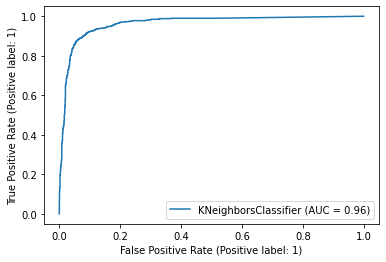

In [ ]:
### KNN ### 
max_cv_score_knn = max(cv_scores_knn)
max_cv_score_idx_knn = cv_scores_knn.index(max_cv_score_knn)
print('KNN cross validation 5-fold:\nBest', count, 'selected features:', comb[max_cv_score_idx_knn], '\nHighest cv (mean) score:', max_cv_score_knn)
new_features_knn = list(comb[max_cv_score_idx_knn])


knn.fit(x_train_knn[new_features_knn], y_train_knn)
metrics.plot_roc_curve(knn, x_test_knn[new_features_knn], y_test_knn)  
plt.show() 

In [ ]:
x_train_knn.head()

,Island,Promoter_Associated,percentage_pos,observed_to_expected_ratio,CCGG,CATG,GCGG,GGCG,CCGC,CGCC,GCGC,CGCG
0,1,0,0.803401,0.713165,8,6,9,9,8,12,11,8
1,1,0,0.680427,0.504417,5,8,2,3,3,1,4,2
5,1,1,0.210255,0.711738,12,4,7,8,14,12,4,7
6,1,0,0.263555,0.837202,28,2,31,33,26,21,26,26
7,0,0,0.023773,0.418352,8,6,11,9,5,9,7,2


In [ ]:
train_all.head()

,Body,TSS200,5'UTR,1stExon,TSS1500,3'UTR,Promoter_Associated,Unclassified,Gene_Associated,Unclassified_Cell_type_specific,...,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT,Is-GC,percentage_pos
0,2,0,0,0,0,0,0,0,0,0,...,3,7,12,13,16,22,15,17,True,0.803401
1,0,1,0,0,0,0,0,0,0,0,...,10,8,2,7,22,18,5,20,False,0.680427
5,0,0,0,2,0,0,1,0,0,0,...,1,6,9,2,7,12,6,9,True,0.210255
6,0,1,2,0,0,0,0,1,0,0,...,5,6,5,5,1,3,8,2,True,0.263555
7,0,0,0,0,0,0,0,0,0,0,...,6,7,3,3,3,6,7,2,False,0.023773


In [ ]:
### KNN ###
# accuracy for using 12 features
knn_fit_12 = knn.fit(x_train_knn, y_train_knn)
knn_cv_score_12 = cross_val_score(knn_fit_12, x_train_knn, y_train_knn, cv=5)

print("12 features: ", np.mean(knn_cv_score_12))

# accuracy for using all features
train_all = train.drop(['Beta', 'seq', 'Forward_Sequence'], axis = 1)
knn_fit_all = knn.fit(train_all, y_train_knn)
knn_cv_score_all = cross_val_score(knn_fit_all, train_all, y_train_knn, cv=5)

print("all features: ", np.mean(knn_cv_score_all))

# accuracy for 7 best features
knn_fit_7 = knn.fit(x_train_knn[new_features_knn], y_train_knn)
knn_cv_score_7 = cross_val_score(knn_fit_12, x_train_knn[new_features_knn], y_train_knn, cv=5)

print("7 features: ", np.mean(knn_cv_score_7))

12 features:  0.8775684931506849
all features:  0.6397831050228311
7 features:  0.9017123287671233


0.920997920997921


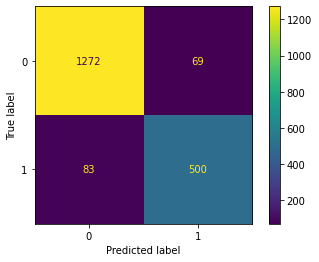

In [ ]:
### KNN ###
from sklearn.metrics import plot_confusion_matrix

# create final knn model that is trained on full training dataset
# with the 7 best features

knn_fit = knn.fit(x_train_knn[new_features_knn], y_train_knn)

knn_y_pred_7 = knn_fit.predict(x_test_knn[new_features_knn])
acc_knn_7 = knn_fit.score(x_test_knn[new_features_knn], y_test_knn)
print(acc_knn_7)

# confusion matrix
plot_confusion_matrix(knn_fit, x_test_knn[new_features_knn], y_test_knn)
plt.show()

0.6356548856548857


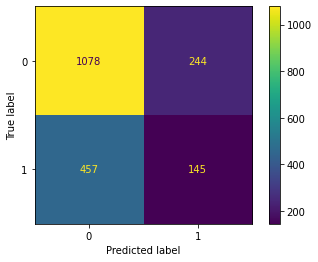

In [ ]:
### KNN ###
train_all = train.drop(['Beta', 'seq', 'Forward_Sequence'], axis = 1)
knn_val_all = tests[2].drop(['Beta', 'seq', 'Forward_Sequence'], axis = 1) # test_all ->  knn_val_all

# create final model trained on full dataset with all features
knn_fit_all = knn.fit(train_all, y_train_knn)
knn_y_pred_all = knn_fit_all.predict(knn_val_all)
acc_knn_all = knn_fit_all.score(knn_val_all, y_val_knn)
print(acc_knn_all)

# confusion matrix
plot_confusion_matrix(knn_fit_all, knn_val_all, y_val_knn)
plt.show()

In [ ]:
# metrics.roc_auc_score(y, y_pred)
print(metrics.roc_auc_score(y_test_knn, knn_y_pred_7))
print(metrics.roc_auc_score(y_val_knn, knn_y_pred_all))

0.903089397201085
0.5281474761385397


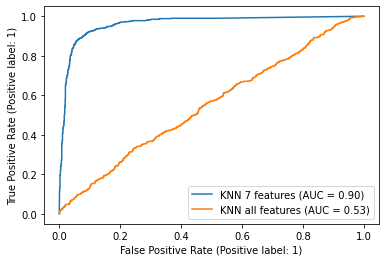

In [ ]:
### KNN ###
# ROC plot for best selected features
knn_roc_7 = metrics.plot_roc_curve(knn.fit(x_train_knn[new_features_knn], y_train_knn),x_test_knn[new_features_knn], y_test_knn, label= 'KNN 7 features (AUC = 0.90)')
knn_roc_all = metrics.plot_roc_curve(knn.fit(train_all, y_train_knn), knn_val_all, y_val_knn, ax=knn_roc_7.ax_, label= 'KNN all features (AUC = 0.53)')
plt.show()

In [ ]:
### DECISION TREE ###
from sklearn.tree import DecisionTreeClassifier

# chosen 12 features from the statistical testing (mutual info, chi2)
features = ['Island','Promoter_Associated','percentage_pos','observed_to_expected_ratio','CCGG','CATG','GCGG', 'GGCG', 'CCGC', 'CGCC', 'GCGC', 'CGCG']

x_train_tree = train[features]
y_train_tree = train['Beta']

x_val_tree = tests[4][features]
y_val_tree = tests[4]['Beta']

x_test_tree = tests[5][features]
y_test_tree = tests[5]['Beta']

In [ ]:
### DECISION TREE ###
## GRID SEARCH ##
tree_test = DecisionTreeClassifier(random_state=11)

# try all combinations of gini vs entropy and tree depth 1-20
parameters = {'criterion': ('gini', 'entropy'), 'max_depth': list(range(1,20,1))}

clf = GridSearchCV(tree_test, parameters)
clf.fit(x_train_tree, y_train_tree)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=11),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19]})

In [ ]:
### DECISION TREE ###
print(clf.best_estimator_, clf.best_score_)

DecisionTreeClassifier(max_depth=6, random_state=11) 0.9306506849315068


In [ ]:
### DECISION TREE ###
results = pd.DataFrame(clf.cv_results_)
results = results.sort_values(by=['rank_test_score'])

gini = []
entropy = []
mean_test_scores = results['mean_test_score']
for item in range(len(mean_test_scores)):
    if results['param_criterion'][item] == 'gini':
        gini.append([results['param_max_depth'][item], mean_test_scores[item]])
    if results['param_criterion'][item] == 'entropy':
        entropy.append([results['param_max_depth'][item], mean_test_scores[item]])


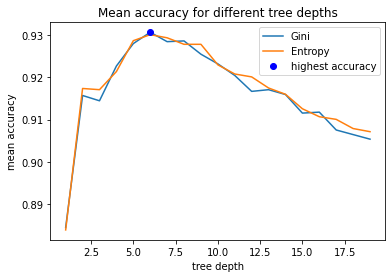

In [ ]:
### DECISION TREE ###
# visualization
results_gini = pd.DataFrame({'tree_depth':[item[0] for item in gini],'mean_cv_score':[item[1] for item in gini]})
results_entropy = pd.DataFrame({'tree_depth':[item[0] for item in entropy],'mean_cv_score':[item[1] for item in entropy]})

plt.plot(results_gini['tree_depth'],results_gini['mean_cv_score'], label='Gini')
plt.plot(results_entropy['tree_depth'],results_entropy['mean_cv_score'], label='Entropy')
plt.plot(6,clf.best_score_,'bo', label='highest accuracy')

# Add the labels and title
plt.gca().set(xlabel='tree depth', ylabel='mean accuracy',title='Mean accuracy for different tree depths')
plt.legend()
plt.show()

In [ ]:
### DECISION TREE ###
## SELECT BEST 7 FEATURES ##

tree = clf.best_estimator_

count = 7
comb = list(combinations(features, count))

# Test cv scores of all possible combinations
cv_scores_tree = []

for i in comb:
    data = x_train_tree[list(i)]
    # perform cross validation 5-fold
    cv_tree = cross_val_score(tree, data, y_train_tree, cv=5, n_jobs = -1)
    cv_scores_tree.append(np.mean(cv_tree))

In [ ]:
### DECISION TREE ###
## selection of best features for tree ##

max_cv_score_tree = max(cv_scores_tree)
max_cv_score_idx_tree = cv_scores.index(max_cv_score_tree)
print('Decision tree cross validation 5-fold:\nBest', count, 'selected features:', comb[max_cv_score_idx_tree], '\nHighest cv (mean) score:', max_cv_score_tree)
new_features_tree = list(comb[max_cv_score_idx_tree])

Decision tree cross validation 5-fold:
Best 7 selected features: ('Promoter_Associated', 'percentage_pos', 'observed_to_expected_ratio', 'CATG', 'CGCC', 'GCGC', 'CGCG') 
Highest cv (mean) score: 0.9333904109589041


In [ ]:
### DECISION TREE ###
# accuracy for using 12 features
tree_fit_12 = tree.fit(x_train_tree, y_train_tree)
cv_score_12 = cross_val_score(tree_fit_12, x_train_tree, y_train_tree, cv=5)

print("12 features: ", np.mean(cv_score_12))

# accuracy for using all features
train_all = train.drop(['Beta', 'seq', 'Forward_Sequence'], axis = 1)
tree_fit_all = tree.fit(train_all, y_train_tree)
cv_score_all = cross_val_score(tree_fit_all, train_all, y_train_tree, cv=5)

print("all features: ", np.mean(cv_score_all))

# accuracy for 7 best features
tree_fit_7 = tree.fit(x_train_tree[new_features_tree], y_train_tree)
cv_score_7 = cross_val_score(tree_fit_12, x_train_tree[new_features_tree], y_train_tree, cv=5)

print("7 features: ", np.mean(cv_score_7))

12 features:  0.9306506849315068
all features:  0.933675799086758
7 features:  0.9333904109589041


0.9454261954261954


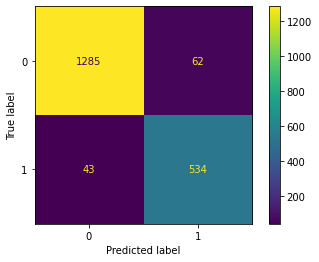

In [ ]:
### DECISION TREE ###
from sklearn.metrics import plot_confusion_matrix

# create final tree model that is trained on full training dataset
# with the 7 best features

tree_fit = tree.fit(x_train_tree[new_features_tree], y_train_tree)

y_pred_7 = tree_fit.predict(x_test_tree[new_features_tree])
acc_tree_7 = tree_fit.score(x_test_tree[new_features_tree], y_test_tree)
print(acc_tree_7)

# confusion matrix
plot_confusion_matrix(tree_fit, x_test_tree[new_features_tree], y_test_tree)
plt.show()


0.9475051975051975


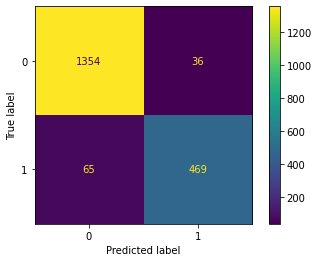

In [ ]:
### DECISION TREE ###
# complete dataset without beta
train_all = train.drop(['Beta', 'seq', 'Forward_Sequence'], axis = 1)
test_all = tests[4].drop(['Beta', 'seq', 'Forward_Sequence'], axis = 1)

# create final model trained on full dataset with all features
tree_fit_all = tree.fit(train_all, y_train_tree)

y_pred_all = tree_fit_all.predict(test_all)
acc_tree_all = tree_fit_all.score(test_all, y_val_tree)
print(acc_tree_all)

# confusion matrix
plot_confusion_matrix(tree_fit_all, test_all, y_val_tree)
plt.show()

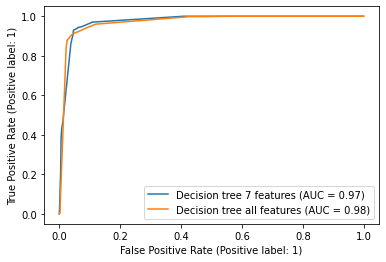

In [ ]:
### DECISION TREE ###
# ROC-plots #

# ROC plot for best selected features
roc_7 = metrics.plot_roc_curve(tree.fit(x_train_tree[new_features_tree], y_train_tree), x_test_tree[new_features_tree], y_test_tree, label= 'Decision tree 7 features (AUC = 0.97)')  
roc_all = metrics.plot_roc_curve(tree.fit(train_all, y_train_tree), test_all, y_val_tree, ax=roc_7.ax_, label= 'Decision tree all features (AUC = 0.98)')
plt.show() 

0.6948630136986301


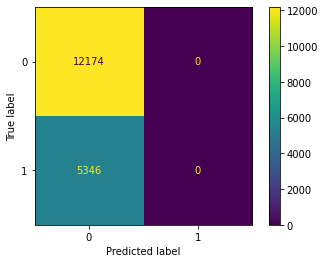

0.7733887733887734


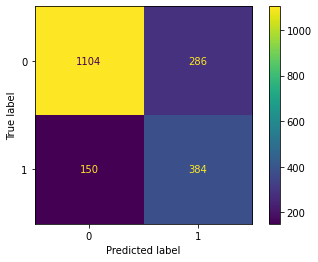

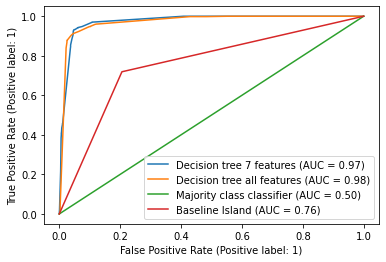

In [ ]:
## BASELINE MAJORITY CLASS ##
from sklearn.dummy import DummyClassifier
maj_class = DummyClassifier(strategy="most_frequent")
MC_fit = maj_class.fit(train_all, y_train_tree)

acc_MC = MC_fit.score(train_all, y_train_tree)
print(acc_MC)

# confusion matrix
plot_confusion_matrix(MC_fit, train_all, y_train_tree)
plt.show()

## BASELINE DECISION TREE ONLY ISLAND ##
bas_isl = DecisionTreeClassifier(random_state=3)
train_island = np.array(train_all['Island']).reshape(-1, 1)
test_island = np.array(test_all['Island']).reshape(-1, 1)

BI_fit = bas_isl.fit(train_island, y_train_tree)

acc_BI = BI_fit.score(test_island, y_val_tree)
print(acc_BI)

# confusion matrix
plot_confusion_matrix(BI_fit, test_island, y_val_tree)
plt.show()

# ROC-plots #

# ROC plot for best selected features
roc_7 = metrics.plot_roc_curve(tree.fit(x_train_tree[new_features_tree], y_train_tree), x_test_tree[new_features_tree], y_test_tree, label= 'Decision tree 7 features (AUC = 0.97)')  
roc_all = metrics.plot_roc_curve(tree.fit(train_all, y_train_tree), test_all, y_val_tree, ax=roc_7.ax_, label= 'Decision tree all features (AUC = 0.98)')
 
# ROC plot for baselines
roc_MC = metrics.plot_roc_curve(MC_fit, train_all, y_train_tree, ax=roc_7.ax_, label = 'Majority class classifier (AUC = 0.50)')  
roc_BI = metrics.plot_roc_curve(BI_fit, test_island, y_val_tree, ax=roc_7.ax_, label = 'Baseline Island (AUC = 0.76)')
plt.show() 


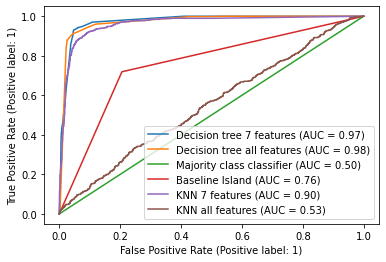

In [ ]:
# ROC plots for all#

roc_7 = metrics.plot_roc_curve(tree.fit(x_train_tree[new_features_tree], y_train_tree), x_test_tree[new_features_tree], y_test_tree, label= 'Decision tree 7 features (AUC = 0.97)')  
roc_all = metrics.plot_roc_curve(tree.fit(train_all, y_train_tree), test_all, y_val_tree, ax=roc_7.ax_, label= 'Decision tree all features (AUC = 0.98)')
 
roc_MC = metrics.plot_roc_curve(MC_fit, train_all, y_train_tree, ax=roc_7.ax_, label = 'Majority class classifier (AUC = 0.50)')  
roc_BI = metrics.plot_roc_curve(BI_fit, test_island, y_val_tree, ax=roc_7.ax_, label = 'Baseline Island (AUC = 0.76)')

knn_roc_7 = metrics.plot_roc_curve(knn.fit(x_train_knn[new_features_knn], y_train_knn),x_test_knn[new_features_knn], y_test_knn, ax=roc_7.ax_, label= 'KNN 7 features (AUC = 0.90)')
knn_roc_all = metrics.plot_roc_curve(knn.fit(train_all, y_train_knn), knn_val_all, y_val_knn, ax=roc_7.ax_, label= 'KNN all features (AUC = 0.53)')

plt.show() 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddf6b85a-936f-43e7-bfb4-c1fea12493a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>